In [0]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as st
import matplotlib.pyplot as plt
import networkx as nx
import time
import numpy

try:
    from numba import jit,vectorize,float64,float32,int64,int32,boolean,guvectorize
    print("Imported Numba")
except ImportError:
    !pip install numba
    try:
        from numba import jit,vectorize,float64,float32,int64,int32,boolean,guvectorize
        print("Imported Numba")
    except ImportError:
        print("Error")
    pass    
pass

Imported Numba


# EPIDEMIC THRESHOLD IN THE SIS DYNAMICS

In [0]:
#########################################################
####### NETWORKS LOADING AND ADJ. MATRIX CREATION #######
#########################################################

net1 = np.loadtxt('net1.txt', dtype=int)
net2 = np.loadtxt('net2.txt', dtype=int)
N1 = np.max(net1.reshape(-1))+1
N2 = np.max(net2.reshape(-1))+1

G1 = nx.Graph()
adj1 = np.zeros((N1, N1),dtype=int)
adj2= np.zeros((N2, N2),dtype=int)
                    
for k in range(net1.shape[0]):
  edge = net1[k]
  G1.add_edge(edge[0], edge[1])
  G1.add_edge(edge[1], edge[0])
  adj1[edge[0], edge[1]]=1
  adj1[edge[1], edge[0]]=1
G2 = nx.Graph()
for k in range(net2.shape[0]):
  edge = net2[k]
  G2.add_edge(edge[0], edge[1])
  G2.add_edge(edge[1], edge[0])
  adj2[edge[0], edge[1]]=1
  adj2[edge[1], edge[0]]=1

In [0]:
#########################################################
######### COMPUTATION OF SOME NETWORK PARAMETERS ########
#########################################################

mu=0.5
k1 = np.array(list(dict(nx.degree(G1)).values()))
k1_m1 = np.mean(k1)
k1_m2 = np.mean(k1**2)
eigs1,_ = np.linalg.eigh(adj1)
k2 = np.array(list(dict(nx.degree(G2)).values()))
k2_m1 = np.mean(k2)
k2_m2 = np.mean(k2**2)
eigs2,_ = np.linalg.eigh(adj2)
print('First network:')
print('Degree First moment:', k1_m1)
print('Degree Second moment:', k1_m2)
print('Ratio:', k1_m2/k1_m1)
print('Biggest eigenvalue:', eigs1[-1])
print('MF-SIS', mu/k1_m1)
print('HMF-SIS', mu*k1_m1/k1_m2)
print('QMF-SIS', mu/eigs1[-1])
print('------------------')
print('Second network:')
print('Degree First moment:', k2_m1)
print('Degree Second moment:', k2_m2)
print('Ratio:', k2_m2/k2_m1)
print('Biggest eigenvalue:', eigs2[-1])
print('MF-SIS', mu/k2_m1)
print('HMF-SIS', mu*k2_m1/k2_m2)
print('QMF-SIS', mu/eigs2[-1])

First network:
Degree First moment: 5.146
Degree Second moment: 31.53
Ratio: 6.127089001165954
Biggest eigenvalue: 6.2841028057033
MF-SIS 0.0971628449280995
HMF-SIS 0.08160482080558198
QMF-SIS 0.07956585298798932
------------------
Second network:
Degree First moment: 3.592
Degree Second moment: 23.67
Ratio: 6.589643652561247
Biggest eigenvalue: 7.5301661877183275
MF-SIS 0.13919821826280623
HMF-SIS 0.07587663709336713
QMF-SIS 0.06639959697244108


# STOCHASTIC SIS MODEL
Because of python speed limitations we wrote a part of the simulation code using c++ and we created some csv output file that we loaded and analyzed here

In [0]:
#########################################################
####### ALGORITHMS FOR SIS SIMULATION ON NETWORKS #######
#########################################################

@jit
def get_nn(adj):
  N = adj.shape[0]
  nn = []
  for i in range(N):
    nn.append(np.nonzero(adj[i,:])[0])
  return nn


### the simulation here has been deprecated and substituted with a C++ based simulation
@jit
def launch_sis_gillespie(adj, lmbd, mu, maxInfected, iters, nSamples, verbosity_time):
    N = adj.shape[0]
    s = np.zeros((nSamples, N))
    for n in range(nSamples):
        s[n,np.random.choice(N, size=maxInfected)]=1 #initialize a max number of maxInfected sites to infected status
    nn = get_nn(adj)
    degs = np.sum(adj, axis=1)
    for t in range(iters):
        s_new = s.copy()
        for i in range(N):
            ill_nn = np.sum(s[:,nn[i]], axis=1)
            susc_nn = degs[i]-ill_nn
            p_rec = mu/(mu+lmbd*susc_nn)
            for n in range(nSamples):
                if(s[n,i]==1):
                    if(np.random.rand()<p_rec[n]):
                        s_new[n,i]=0
                    else:
                        j = np.random.choice(np.intersect1d(np.nonzero(s[n,:]==0) ,nn[i]))
                        s_new[n,j]=1   
        s = s_new
        if(verbosity_time != 0 and t %verbosity_time==0):
            print(int(t/iters*100), '%')
    return s
  


@jit
def launch_sis_probabilistic(adj, lmbd, mu, maxInfected, iters=300, nSamples=30, verbosity_time=5):
    N = adj.shape[0]
    s = np.zeros((nSamples, N))
    for n in range(nSamples):
        s[n,np.random.choice(N, size=maxInfected)]=1 #initialize a max number of maxInfected sites to infected status
    degs = np.sum(adj, axis=1)
    nn = []
    for i in range(N):
        nn.append(np.nonzero(adj[i,:])[0])
        
    for t in range(iters):
        s_new = s.copy()
        for i in range(N):
            ill_nn = np.sum(s[:,nn[i]], axis=1)
            p_inf = 1-(1-lmbd)**ill_nn
            for n in range(nSamples):
                if(s[n,i]==0 and np.random.rand()<p_inf[n]):
                    s_new[n,i]=1
                elif(s[n,i]==1 and np.random.rand()<mu):
                    s_new[n,i]=0
        s = s_new
        if(verbosity_time != 0 and t %verbosity_time==0):
            print(int(t/iters*100), '%')
    return s
  


In [0]:
def launch_simulation(adj, lmbd, mu, maxInfected, iters, nSamples, verbosity_time, method): #method: 0 - GillespieLocal; 1 - Prob
    N = adj.shape[0]
    inff = np.zeros(len(lmbd))    
    if(method==0):
        funcsim = launch_sis_gillespie
    else:
        funcsim = launch_sis_probabilistic
    inff = np.zeros(len(lmbd))
    infstd = np.zeros(len(lmbd))
    for k,l in enumerate(lmbd):
        result = np.sum(funcsim(adj,l, mu,maxInfected,iters, nSamples, verbosity_time), axis=1)/N
        inff[k]=np.mean(result)
        infstd[k] = np.std(result)
        #print('Lambda:', l, 'Infected:', inff[k])
        #print('--------------')
    return inff, infstd

In [0]:
method = 1 #method: 0 - Gillespie; 1 - Prob
lmbd = np.linspace(0.01, 1, 100)
maxInfected = 5
iters = 100
nSamples = 100
verbosity_time = 0
inf1, inf1std = launch_simulation(adj1, lmbd, mu, maxInfected, iters, nSamples, verbosity_time, method)
inf2, inf2std = launch_simulation(adj2, lmbd, mu, maxInfected, iters, nSamples, verbosity_time, method)

In [0]:
#data generated by C++ program
ls = np.linspace(0.01, 1, 500)
res = np.loadtxt('net1_out.txt')
i1 = np.mean(res[:, 1:], axis=1)
i1std=np.std(res[:, 1:], axis=1)
res = np.loadtxt('net2_out.txt')
i2 = np.mean(res[:, 1:], axis=1)
i2std=np.std(res[:, 1:], axis=1)

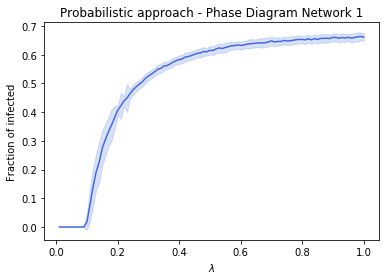

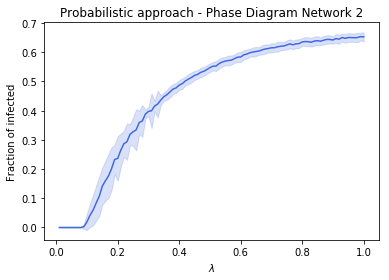

In [0]:
plt.figure()
plt.plot(lmbd, inf1, c='royalblue')
plt.xlabel('$\lambda$')
plt.ylabel('Fraction of infected')
plt.title('Probabilistic approach - Phase Diagram Network 1')
plt.fill_between(lmbd, inf1-inf1std, inf1+inf1std, color='royalblue', alpha=0.2)
plt.savefig('images/net1_pd_prob.png', bbox_inches='tight')
plt.show()
plt.figure()
plt.plot(lmbd, inf2, c='royalblue')
plt.xlabel('$\lambda$')
plt.ylabel('Fraction of infected')
plt.title('Probabilistic approach - Phase Diagram Network 2')
plt.fill_between(lmbd, inf2-inf2std, inf2+inf2std, color='royalblue', alpha=0.2)
plt.savefig('images/net2_pd_prob.png', bbox_inches='tight')
plt.show()

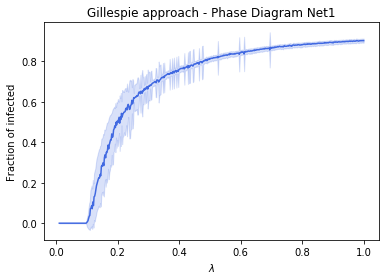

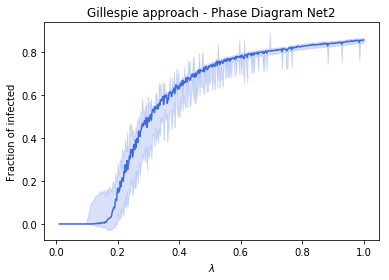

In [0]:
plt.figure()
plt.plot(ls, i1, c='royalblue')
plt.xlabel('$\lambda$')
plt.ylabel('Fraction of infected')
plt.title('Gillespie approach - Phase Diagram Net1')
plt.fill_between(ls, i1-i1std, i1+i1std, color='royalblue', alpha=0.2)
plt.savefig('images/net1_pd_gill.png', bbox_inches='tight')
plt.show()
plt.figure()
plt.plot(ls, i2, c='royalblue')
plt.xlabel('$\lambda$')
plt.ylabel('Fraction of infected')
plt.fill_between(ls, i2-i2std, i2+i1std, color='royalblue', alpha=0.2)
plt.title('Gillespie approach - Phase Diagram Net2')
plt.savefig('images/net2_pd_gill.png', bbox_inches='tight')
plt.show()

In [0]:
from scipy.optimize import curve_fit

def funct(x,a,lam_crit,c):
  val = c+((x-lam_crit)/lam_crit)**a #the lam_crit is not actually the real value of lambda critical!
  return val*(val>0)

def strange_fit(func, xs, ys, num_points=5, thresh=0.015):
  validx = xs[ys>thresh][:num_points]    
  validy = ys[ys>thresh][:num_points] #only points above the threshold are used
  popt, pcov = curve_fit(func, validx, validy, p0=(0.5, 0.06, 1.2)) #some intialization is needed...
  return popt

def get_lambda_critical(lmbds, infRatio):
    params = strange_fit(funct, lmbds, infRatio, num_points=20)
    return ls[np.argmax(funct(lmbds, *params)>0)]

def get_critical(lmbds, infRatio, tol):
    lastZero = (np.nonzero(infRatio<=tol)[0])[-1]
    return lmbds[lastZero+1]

def get_critical2(lmbds, infRatio, amount, tol):
    lastZero = (np.nonzero(infRatio<=tol)[0])[-1]
    fitIndices = np.arange(lastZero+1, lastZero+amount+1)
    params = st.linregress(lmbds[fitIndices], infRatio[fitIndices])
    return -params[1]/params[0]
print('Gillespie Lambda Critical Net 1:',get_critical(ls, i1,1E-2))
print('Gillespie Lambda Critical Net 2:',get_critical(ls, i2,1E-2))
print('Prob Lambda Critical Net 1:',get_critical2(lmbd, inf1, 2, 0))
print('Prob Lambda Critical Net 2:',get_critical2(lmbd, inf2, 2, 0))

Gillespie Lambda Critical Net 1: 0.10324649298597194
Gillespie Lambda Critical Net 2: 0.164749498997996
Prob Lambda Critical Net 1: 0.08985349972870321
Prob Lambda Critical Net 2: 0.08834735576923078


# NETWORK PROPERTIES

In [0]:
@jit
def argmax_n(arr, n):
    mask = np.argsort(arr)
    return mask[-n:][::-1]

In [0]:
labels = ["Clustering", "PageRank", "Betw.Centr.", "Degrees"]


bc1 = np.array(list(dict(nx.betweenness_centrality(G1)).values()))
max_bc1 = argmax_n(bc1, 10)
c1 = np.array(list(dict(nx.clustering(G1)).values()))
max_c1 = argmax_n(c1, 10)
ac1 = nx.average_clustering(G1)
pr1 = np.array(list(dict(nx.pagerank(G1)).values()))
max_pr1 = argmax_n(pr1, 10)
deg1 = np.sum(adj1, axis=1)
max_deg1 = argmax_n(deg1, 10)

bc2 = np.array(list(dict(nx.betweenness_centrality(G2)).values()))
max_bc2 = argmax_n(bc2, 10)
c2 = np.array(list(dict(nx.clustering(G2)).values()))
max_c2 = argmax_n(c2, 10)
ac2 = nx.average_clustering(G2)
pr2 = np.array(list(dict(nx.pagerank(G2)).values()))
max_pr2 = argmax_n(pr2, 10)
deg2 = np.sum(adj2, axis=1)
max_deg2 = argmax_n(deg2, 10)


segr1_ind = [max_bc1, max_c1, max_pr1, max_deg1]
segr1  = []
for n,indices in enumerate(segr1_ind):
    temp = np.delete(adj1, indices, axis=0)
    temp = np.delete(temp, indices, axis=1)
    segr1.append(temp)
    edgeCount = np.sum(temp)
    edges = np.zeros((edgeCount, 2), dtype=int)
    h = 0
    for i in range(temp.shape[0]):
        nn_ind = np.nonzero(temp[i,:])[0]
        for j in range(nn_ind.shape[0]):
            edges[h, 0] = i
            edges[h,1] = nn_ind[j]
            h += 1
    np.savetxt('data/'+labels[n] + '_1.txt', edges, fmt='%d')
    
segr2_ind = [max_bc2, max_c2, max_pr2, max_deg2]
segr2  = []
for n,indices in enumerate(segr2_ind):
    temp = np.delete(adj2, indices, axis=0)
    temp = np.delete(temp, indices, axis=1)
    segr2.append(temp)
    edgeCount = np.sum(temp)
    edges = np.zeros((edgeCount, 2), dtype=int)
    h = 0
    for i in range(temp.shape[0]):
        nn_ind = np.nonzero(temp[i,:])[0]
        for j in range(nn_ind.shape[0]):
            edges[h, 0] = i
            edges[h,1] = nn_ind[j]
            h += 1
    np.savetxt('data/'+labels[n] + '_2.txt', edges, fmt='%d')

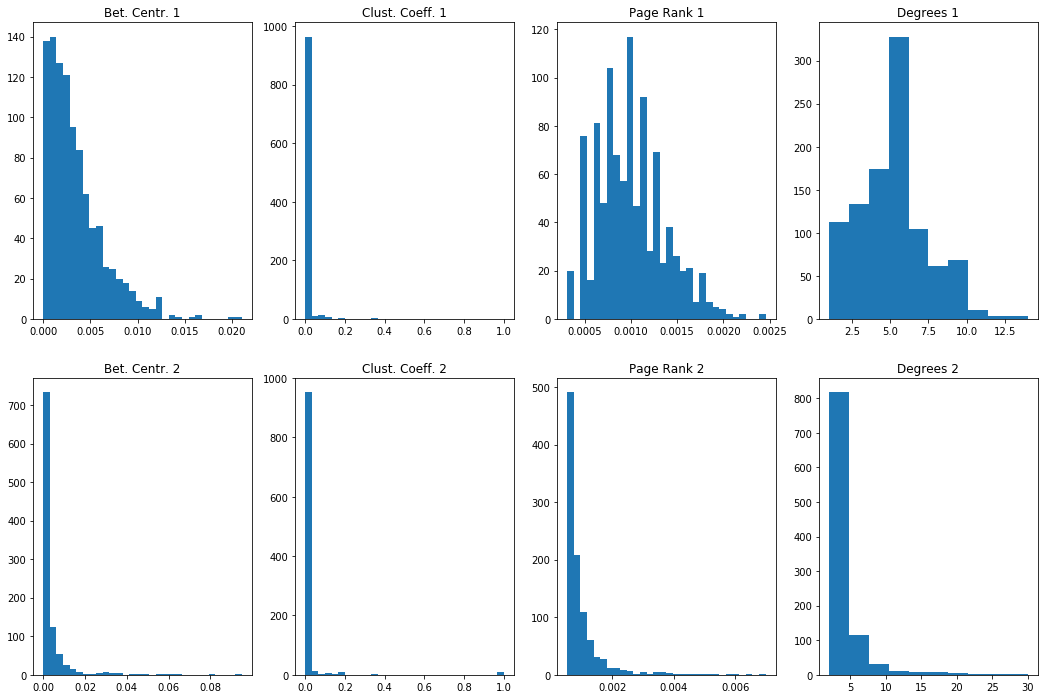

In [0]:
(fix, axs) = plt.subplots(nrows=2, ncols=4, figsize=(18,12))
axs[0,0].hist(bc1, bins=30)
axs[0,0].set_title('Bet. Centr. 1')
axs[0,1].hist(c1, bins=30)
axs[0,1].set_title('Clust. Coeff. 1')
axs[0,2].hist(pr1, bins=30)
axs[0,2].set_title('Page Rank 1')
axs[0,3].hist(deg1)
axs[0,3].set_title('Degrees 1')
axs[1,0].hist(bc2, bins=30)
axs[1,0].set_title('Bet. Centr. 2')
axs[1,1].hist(c2, bins=30)
axs[1,1].set_title('Clust. Coeff. 2')
axs[1,2].hist(pr2, bins=30)
axs[1,2].set_title('Page Rank 2')
axs[1,3].hist(deg2)
axs[1,3].set_title('Degrees 2')
plt.savefig('images/netproperties.png')
plt.show()

# SEGREGATION ANALYSIS

---------------------------
---------------------------
---------------------------
---------------------------


[]

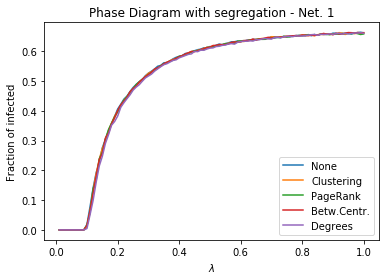

In [0]:
plt.plot(lmbd, inf1, label="None")
plt.title('Phase Diagram with segregation - Net. 1')
plt.xlabel('$\lambda$')
plt.ylabel('Fraction of infected')
infs1 = np.zeros((len(segr1), len(lmbd)))
for n, net in enumerate(segr1):
    infs1[n,:],_ = launch_simulation(segr1[n] , lmbd, mu, maxInfected, iters, nSamples, verbosity_time, method)
    plt.plot(lmbd, infs1[n,:], label=labels[n])
    print('---------------------------')
plt.legend()
plt.savefig('images/net1_pd_segr_prob.png', bbox_inches='tight')
plt.plot()

---------------------------
---------------------------
---------------------------
---------------------------


[]

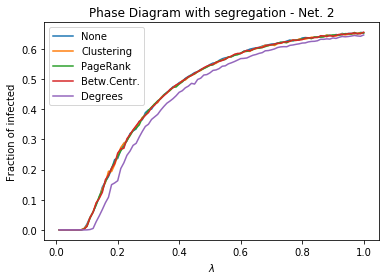

In [0]:
plt.plot(lmbd, inf2, label="None")
plt.title('Phase Diagram with segregation - Net. 2')
plt.xlabel('$\lambda$')
plt.ylabel('Fraction of infected')
infs2 = np.zeros((len(segr2), len(lmbd)))
for n, net in enumerate(segr2):
    infs2[n,:],_ = launch_simulation(segr2[n], lmbd, mu, maxInfected, iters, nSamples, verbosity_time, method)
    plt.plot(lmbd, infs2[n,:], label=labels[n])
    print('---------------------------')
plt.legend()
plt.savefig('images/net2_pd_segr_prob.png', bbox_inches='tight')
plt.plot()

Clustering
PageRank
Betw.Centr.
Degrees


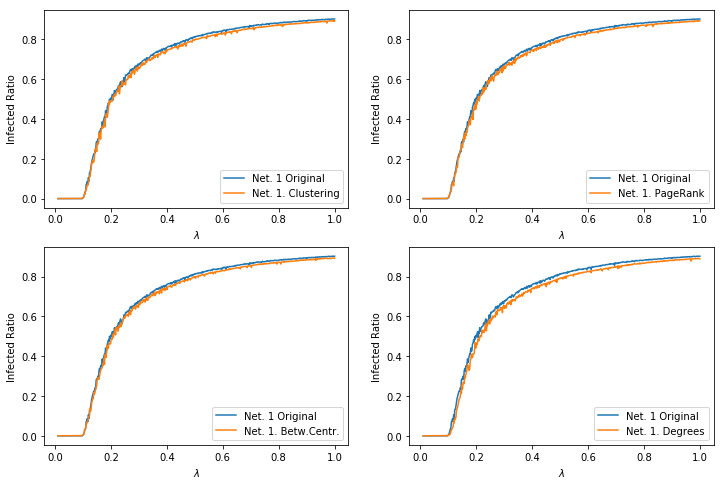

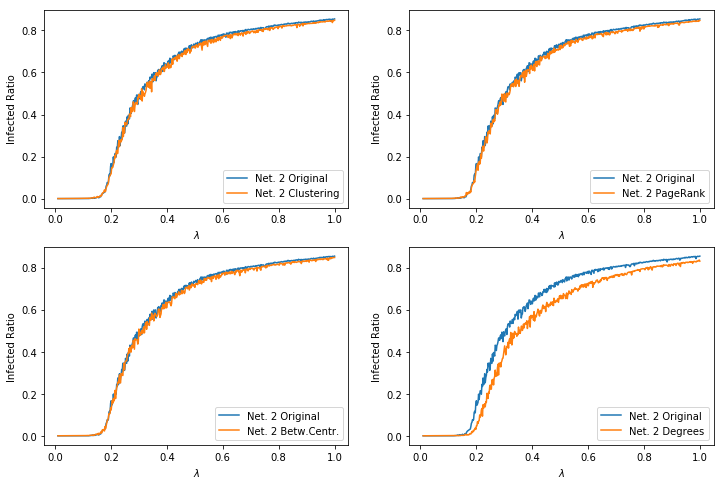

In [0]:
nSegr = len(labels)
(fig1, axs1) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
(fig2, axs2) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
tol = 1E-4
#fig1.suptitle('Segregation Network 1')
#fig2.suptitle('Segregation Network 2')
for n in range(nSegr):
    
    print(labels[n])
    axisRow = n//2
    axisCol = n-2*axisRow
    res = np.loadtxt('data/'+labels[n] +'_1_out.txt')
    infRatio1 = np.mean(res, axis=1)
    axs1[axisRow, axisCol].plot(ls, i1, label='Net. 1 Original')
    axs1[axisRow, axisCol].plot(ls, infRatio1, label='Net. 1. ' + labels[n])
    axs1[axisRow, axisCol].set_xlabel('$\lambda$')
    axs1[axisRow, axisCol].set_ylabel('Infected Ratio')
    axs1[axisRow, axisCol].legend(loc=4)
    res = np.loadtxt('data/'+labels[n] +'_2_out.txt')
    infRatio2 = np.mean(res, axis=1)
    axs2[axisRow, axisCol].plot(ls, i2, label='Net. 2 Original')
    axs2[axisRow, axisCol].plot(ls, infRatio2, label='Net. 2 ' + labels[n])
    axs2[axisRow, axisCol].set_xlabel('$\lambda$')
    axs2[axisRow, axisCol].set_ylabel('Infected Ratio')
    axs2[axisRow, axisCol].legend(loc=4)
fig1.savefig('images/net1_pd_segr_gill.png', bbox_inches='tight')
fig2.savefig('images/net2_pd_segr_gill.png', bbox_inches='tight')
plt.show()

### Critical parameter estimation

In [0]:
###########
# FITTING #
###########
labels = ["Clustering", "PageRank", "Betw.Centr.", "Degrees"]
ls = np.linspace(0.01, 1, 500)

#segregation
for n in range(len(labels)):
    res = np.loadtxt('data/'+labels[n] +'_1_out.txt')
    infRatio = np.ravel(np.mean(res[:,1:], axis=1))
    print(labels[n], ": for network 1 the epidemic threshold is lambda_C =", get_lambda_critical(ls, infRatio))
    res = np.loadtxt('data/'+labels[n] +'_2_out.txt')
    infRatio = np.ravel(np.mean(res[:,1:], axis=1))
    print(labels[n], ": for network 2 the epidemic threshold is lambda_C =", get_lambda_critical(ls, infRatio))

Clustering : for network 1 the epidemic threshold is lambda_C = 0.10523046092184368
Clustering : for network 2 the epidemic threshold is lambda_C = 0.1687174348697395
PageRank : for network 1 the epidemic threshold is lambda_C = 0.10523046092184368


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


PageRank : for network 2 the epidemic threshold is lambda_C = 0.1687174348697395
Betw.Centr. : for network 1 the epidemic threshold is lambda_C = 0.10324649298597194
Betw.Centr. : for network 2 the epidemic threshold is lambda_C = 0.1687174348697395
Degrees : for network 1 the epidemic threshold is lambda_C = 0.10919839679358717
Degrees : for network 2 the epidemic threshold is lambda_C = 0.18657314629258517


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


# SIR DYNAMICS

In [0]:
df = pd.read_csv('cases_100locations_first77days.txt', sep=' ')
df.columns = ['X', 'D', 'S', 'I', 'R']

In [0]:
fromX = df['X'].min()
toX = df['X'].max()
nLocs = toX-fromX+1
betas = np.zeros(nLocs)
gammas = np.zeros(nLocs)
for i in range(nLocs):
    x = i + fromX
    mask = df['X']==x
    s_x = df[mask]['S'].values
    i_x = df[mask]['I'].values
    r_x = df[mask]['R'].values
    
    
    
    betas[i] = -(s_x[-1] -s_x[0])/np.sum(s_x*i_x)
    gammas[i] = r_x[-1]/np.sum(i_x)
print('Estimated Beta:', np.mean(betas), '+\-', np.std(betas))
print('Estimated Gamma:', np.mean(gammas), '+\-', np.std(gammas))
r0 = betas/gammas
print('Estimated R0:', np.mean(r0), '+\-', np.std(r0))